<a href="https://colab.research.google.com/github/Jadhav2024/case_study/blob/main/mcdonalds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Load the dataset
mcdonalds = pd.read_csv('/content/mcdonalds.csv')

# Inspect basic features
print(mcdonalds.columns)
print(mcdonalds.shape)
print(mcdonalds.head(3))


Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age',
       'VisitFrequency', 'Gender'],
      dtype='object')
(1453, 15)
  yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0    No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
1   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes       Yes      No   
2    No        Yes   Yes       Yes    Yes  Yes    No   Yes       Yes     Yes   

  disgusting Like  Age      VisitFrequency  Gender  
0         No   -3   61  Every three months  Female  
1         No   +2   51  Every three months  Female  
2         No   +1   62  Every three months  Female  


In [ ]:
import numpy as np

# Convert YES/NO to binary (1 for Yes, 0 for No)
MD_x = mcdonalds.iloc[:, 0:11].applymap(lambda x: 1 if x == "Yes" else 0)

# Compute column means
means = MD_x.mean().round(2)
print(means)


yummy         0.55
convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy       0.20
disgusting    0.24
dtype: float64


<ipython-input-4-6a4bd7378991>:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  MD_x = mcdonalds.iloc[:, 0:11].applymap(lambda x: 1 if x == "Yes" else 0)


In [ ]:
from sklearn.cluster import KMeans

# Define function to perform k-means clustering for k=2 to 8
def kmeans_clustering(data, k_range):
    models = {}
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=1234, n_init=10)
        models[k] = kmeans.fit(data)
    return models

# Apply k-means clustering to MD_x
k_range = range(2, 9)
models = kmeans_clustering(MD_x, k_range)


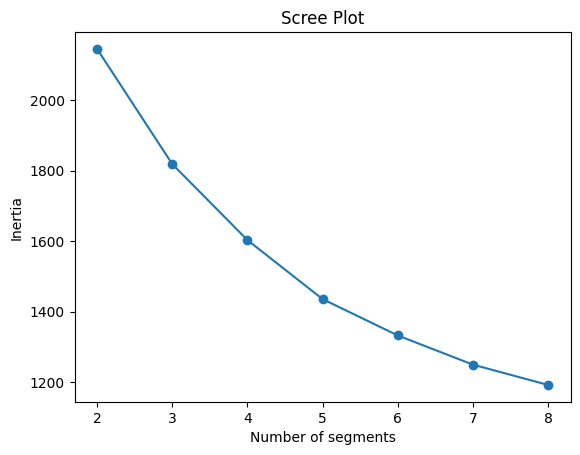

In [ ]:
import matplotlib.pyplot as plt

# Create scree plot
inertia = [model.inertia_ for model in models.values()]
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of segments')
plt.ylabel('Inertia')
plt.title('Scree Plot')
plt.show()


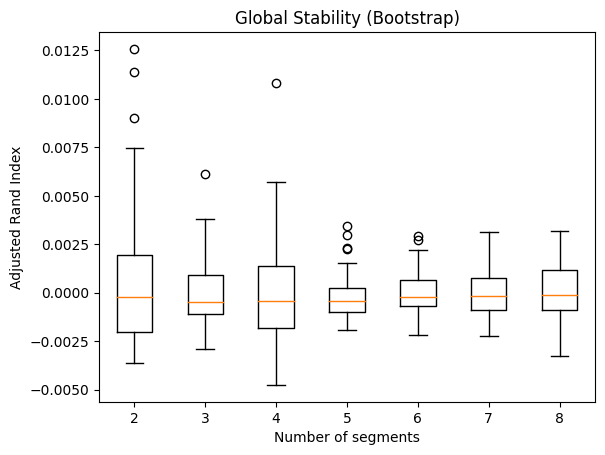

In [ ]:
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample

def bootstrap_kmeans(data, k_range, n_boot=100, n_rep=10):
    stability_scores = {k: [] for k in k_range}

    for k in k_range:
        model = models[k]
        for _ in range(n_boot):
            # Create a bootstrap sample
            sample_data = resample(data)
            # Fit the k-means model to the bootstrap sample
            model.fit(sample_data)
            # Calculate Adjusted Rand Index with original labels
            stability_scores[k].append(adjusted_rand_score(model.labels_, model.predict(data)))

    return stability_scores

# Perform bootstrapping for stability analysis
stability_scores = bootstrap_kmeans(MD_x, k_range)

# Plot stability scores (ARI)
plt.boxplot([stability_scores[k] for k in k_range], labels=k_range)
plt.xlabel('Number of segments')
plt.ylabel('Adjusted Rand Index')
plt.title('Global Stability (Bootstrap)')
plt.show()


In [ ]:
from sklearn.mixture import GaussianMixture

# Fit Gaussian Mixture Models for k=2 to 8
gmm_models = {}
for k in k_range:
    gmm = GaussianMixture(n_components=k, random_state=1234, n_init=10)
    gmm.fit(MD_x)
    gmm_models[k] = gmm

# Get information criteria (AIC, BIC)
for k in k_range:
    print(f'k={k}, AIC={gmm_models[k].aic(MD_x)}, BIC={gmm_models[k].bic(MD_x)}')


k=2, AIC=-21985.641849663745, BIC=-21167.027071810353
k=3, AIC=-27786.89942469458, BIC=-26556.336565082704
k=4, AIC=-34405.083804457085, BIC=-32762.572863086727
k=5, AIC=-44223.86338162657, BIC=-42169.40435849773
k=6, AIC=-56110.08402145094, BIC=-53643.676916563614
k=7, AIC=-58214.95291358821, BIC=-55336.597726942404
k=8, AIC=-52183.62036754436, BIC=-48893.31709914008


In [ ]:
import numpy as np
import pandas as pd  # Make sure you import pandas
import statsmodels.api as sm
from sklearn.cluster import KMeans

# Ensure the data is numeric
X = pd.get_dummies(MD_x, drop_first=True)  # Convert categorical columns to numeric

# Check unique values in 'Like' to understand its contents
print(mcdonalds['Like'].unique())

# Convert 'Like' column to numeric, setting errors='coerce' to convert non-numeric to NaN
mcdonalds['Like'] = pd.to_numeric(mcdonalds['Like'], errors='coerce')

# Handle missing values (fill NaN with the mean of the column or use another strategy)
mcdonalds['Like'].fillna(mcdonalds['Like'].mean(), inplace=True)

# Now, assign y as the dependent variable (target)
y = mcdonalds['Like']

# Perform KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=1234, n_init=10).fit(X)

# Get cluster labels
cluster_labels = kmeans.labels_

# Fit linear regression models for each cluster
for cluster in np.unique(cluster_labels):
    X_cluster = X[cluster_labels == cluster]
    y_cluster = y[cluster_labels == cluster]

    # Add constant term for intercept
    X_cluster = sm.add_constant(X_cluster)

    # Fit linear regression model
    model = sm.OLS(y_cluster, X_cluster).fit()

    # Print regression summary for each cluster
    print(f'Regression for cluster {cluster}:\n', model.summary())


['-3' '+2' '+1' '+4' 'I love it!+5' 'I hate it!-5' '-2' '+3' '0' '-4' '-1']
Regression for cluster 0:
                             OLS Regression Results                            
Dep. Variable:                   Like   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     11.44
Date:                Thu, 10 Oct 2024   Prob (F-statistic):           4.16e-20
Time:                        10:44:11   Log-Likelihood:                -1630.0
No. Observations:                 896   AIC:                             3284.
Df Residuals:                     884   BIC:                             3342.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

<ipython-input-25-a81a36459785>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mcdonalds['Like'].fillna(mcdonalds['Like'].mean(), inplace=True)


Regression for cluster 1:
                             OLS Regression Results                            
Dep. Variable:                   Like   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.950
Date:                Thu, 10 Oct 2024   Prob (F-statistic):             0.0313
Time:                        10:44:11   Log-Likelihood:                -1177.9
No. Observations:                 557   AIC:                             2380.
Df Residuals:                     545   BIC:                             2432.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4163    

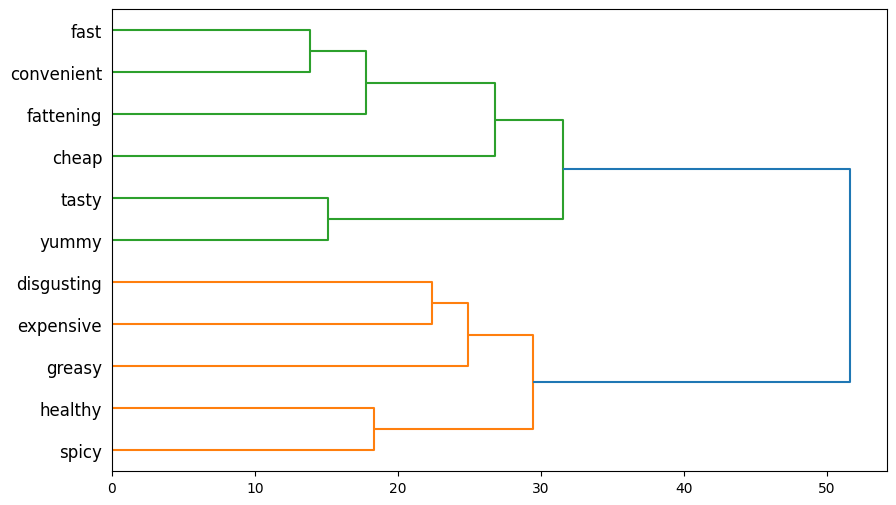

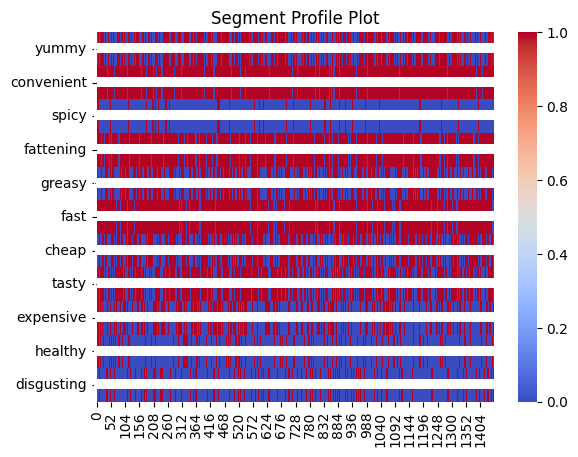

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
import seaborn as sns

# Perform hierarchical clustering on the transposed data
Z = linkage(MD_x.T, method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=MD_x.columns, orientation='right')
plt.show()

# Profile plot using a heatmap
sns.heatmap(MD_x.T, cmap='coolwarm', annot=True)
plt.title('Segment Profile Plot')
plt.show()


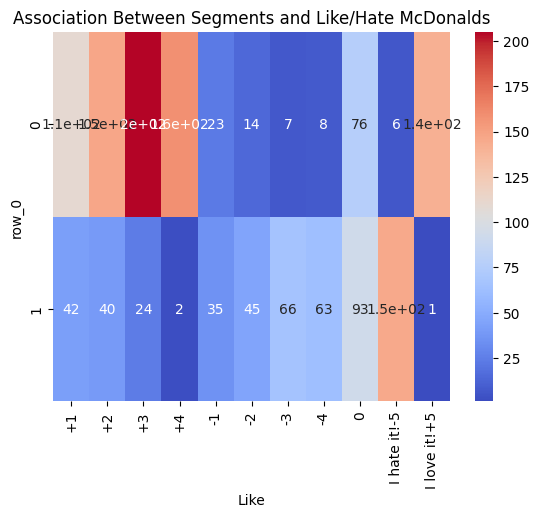

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a cross-tabulation of segments and liking McDonald's
crosstab = pd.crosstab(cluster_labels, mcdonalds['Like'])

# Plot mosaic-style heatmap
sns.heatmap(crosstab, cmap='coolwarm', annot=True)
plt.title('Association Between Segments and Like/Hate McDonalds')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called `mcdonalds`
mcdonalds = pd.DataFrame({
    'Visit': np.random.uniform(2, 4.5, 100),  # Random values for visit frequency
    'Like': np.random.uniform(-3, 3, 100),   # Random values for liking McDonald's
    'Female': np.random.randint(1, 10, 100)   # Random count of females
})

# Extract variables from the DataFrame
visit = mcdonalds['Visit']  # Visit frequency
like = mcdonalds['Like']    # Like rating
female = mcdonalds['Female']  # Count of females



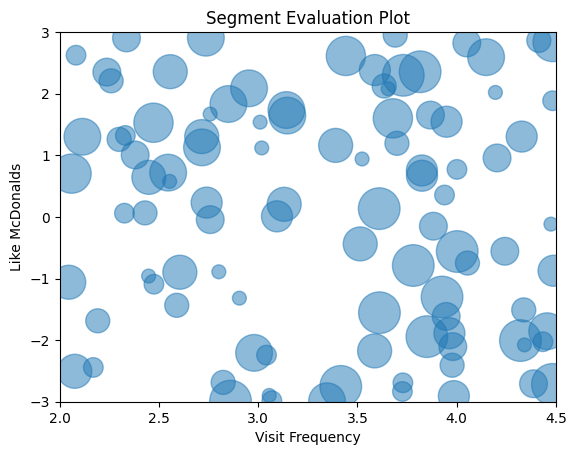

In [ ]:
# Plot segment evaluation plot
plt.scatter(visit, like, s=100 * female, alpha=0.5)
plt.xlim(2, 4.5)
plt.ylim(-3, 3)
plt.xlabel('Visit Frequency')
plt.ylabel('Like McDonalds')
plt.title('Segment Evaluation Plot')
plt.show()
